Using own dataset tried gridsearch preprocessing and random forest to increase model accuracy

In [65]:
# Tree-based classifier with k-fold CV for Loan Approval Dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [66]:
# Load Dataset
df = pd.read_csv("new_loan_approval_dataset.csv")


Preprocessing the data for better accuracy

In [67]:
# 1. Encode categorical columns
# Employment_Type: Label encode all unique values
df['Employment_Type'] = LabelEncoder().fit_transform(df['Employment_Type'])

# Loan_Approved: Convert 'Yes'/'No' to 1/0
df['Loan_Approved'] = df['Loan_Approved'].map({'Yes': 1, 'No': 0})


In [68]:
# 2. Handle missing values (if any)
# Fill numeric columns with median, others with mode
num_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(exclude=['number']).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [69]:
# 3. Remove outliers (optional, example for Income)
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Income'] >= Q1 - 1.5 * IQR) & (df['Income'] <= Q3 + 1.5 * IQR)]


In [70]:
# 4. Feature scaling (Standardize numerical features)
num_cols = ['Age', 'Income', 'Credit_Score', 'Existing_Loans']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [71]:
# 5. Features and Target
X = df[['Age', 'Employment_Type', 'Income', 'Credit_Score', 'Existing_Loans']]
y = df['Loan_Approved']

In [72]:
# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [73]:
# # Encode categorical column 'Employment_Type'
# df['Employment_Type'] = df['Employment_Type'].map({'Unemployed': 0, 'Self-Employed': 1, 'Salaried': 2})


In [74]:
# Feature Engineering Example

# Create new features to help the model
df['Income_per_Loan'] = df['Income'] / (df['Existing_Loans'] + 1)  # Avoid division by zero
df['High_Income'] = (df['Income'] > df['Income'].median()).astype(int)  # Binary feature
df['Young_Applicant'] = (df['Age'] < 40).astype(int)  # Binary feature
df['Good_Credit'] = (df['Credit_Score'] > 750).astype(int)  # Binary feature

# Update features for model training
X = df[['Age', 'Employment_Type', 'Income', 'Credit_Score', 'Existing_Loans',
        'Income_per_Loan', 'High_Income', 'Young_Applicant', 'Good_Credit']]
y = df['Loan_Approved']

In [75]:
# # Features and Target
# X = df[['Age', 'Employment_Type', 'Income', 'Credit_Score', 'Existing_Loans']]
# y = df['Loan_Approved']


In [76]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:
# Decision Tree Classifier
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, random_state=42)

In [78]:
# Predictions and Evaluation
y_pred = dt_model.predict(X_test)
print("Accuracy on Test Data:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy on Test Data: 0.55

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       0.75      0.60      0.67        15

    accuracy                           0.55        20
   macro avg       0.50      0.50      0.49        20
weighted avg       0.62      0.55      0.58        20



In [79]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)



Confusion Matrix:
 [[2 3]
 [6 9]]


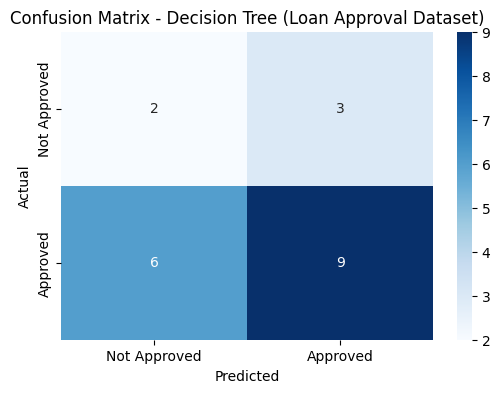

In [80]:
# Visualization
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Approved','Approved'], yticklabels=['Not Approved','Approved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree (Loan Approval Dataset)")
plt.show()


In [81]:
# KFold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(dt_model, X, y, cv=kf)
print("\nScores for each fold:", cv_scores)
print("Mean Accuracy (Cross-Validation):", cv_scores.mean())



Scores for each fold: [0.55 0.6  0.45 0.6  0.55]
Mean Accuracy (Cross-Validation): 0.55


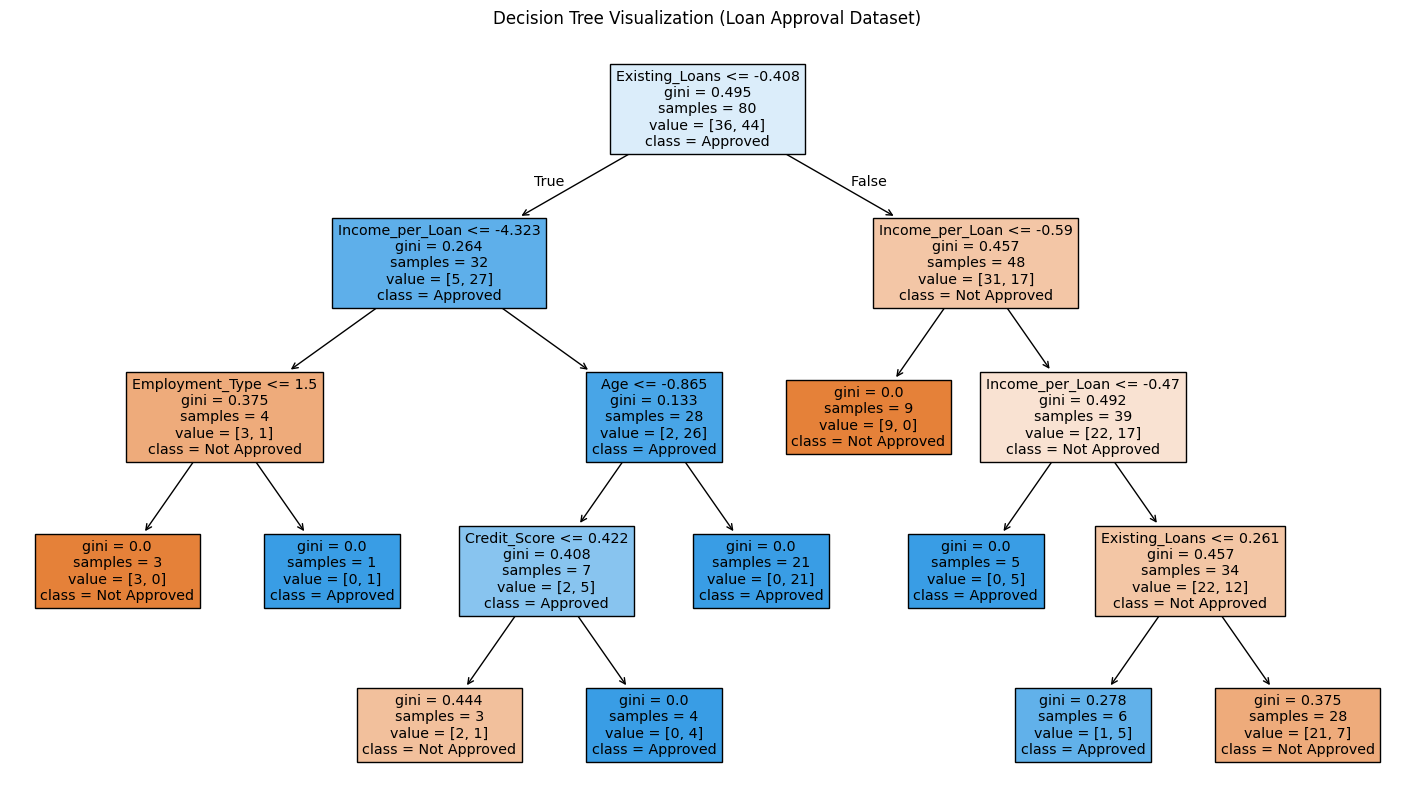

In [82]:
# Decision Tree Visualization
plt.figure(figsize=(18,10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Not Approved','Approved'], filled=True)
plt.title("Decision Tree Visualization (Loan Approval Dataset)")
plt.show()

In [83]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5)
grid.fit(X, y)
print("Best parameters:", grid.best_params_)
print("Best cross-validated accuracy:", grid.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}
Best cross-validated accuracy: 0.76


In [84]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.6


Before preprocessing:

Accuracy on Test Data: 0.45

Classification Report:
               precision    recall  f1-score   support

          No       0.29      0.80      0.42         5
         Yes       0.83      0.33      0.48        15

    accuracy                           0.45        20
   macro avg       0.56      0.57      0.45        20
weighted avg       0.70      0.45      0.46        20

Scores for each fold: [0.45 0.6  0.65 0.5  0.5 ]
Mean Accuracy (Cross-Validation): 0.54

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validated accuracy: 0.75

Random Forest Accuracy: 0.65